In [1]:
!pip install sentence-transformers


[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
!pip install PyMuPDF

  Using cached pymupdf-1.25.5-cp39-abi3-win_amd64.whl.metadata (3.4 kB)
Using cached pymupdf-1.25.5-cp39-abi3-win_amd64.whl (16.6 MB)



[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
!pip install pytesseract


[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [4]:
!pip install Pillow


[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


✅ Dataset-based role matching complete. Output saved to 'matched_resumes_dataset.csv'.



📤 Do you want to upload your own resume as a PDF for analysis?
Type 'yes' to upload, or press Enter to skip:  yes
📄 Enter path to your resume (e.g., resume.pdf):  Resume.pdf


📄 Extracting text from resume...
✅ Resume text extracted. Analyzing...

🎯 Suggested Role Based on Your Resume:
Role: Manager, Large Customer Sales (Spanish)
📍 Location: Dublin, Ireland
📝 Job Description: Manager, Large Customer Sales (Spanish) Manage teams of account managers to deliver excellent performance, develop their digital marketing expertise, and mentor them, providing supportive and honest career evaluations and facilitating professional development plans.
Coach on expansion Sales, Implementation and Measurement to ensure that goals are met by ensuring that key plans are in place and tha...

📊 Generating advanced visualizations...


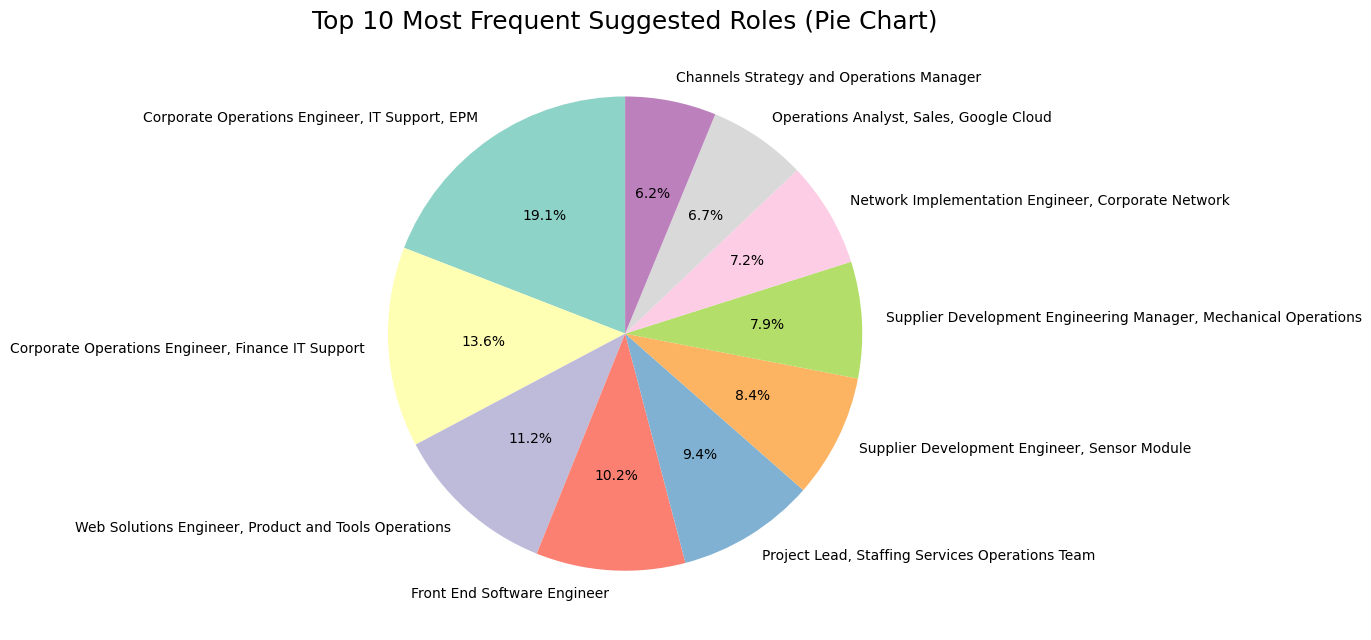

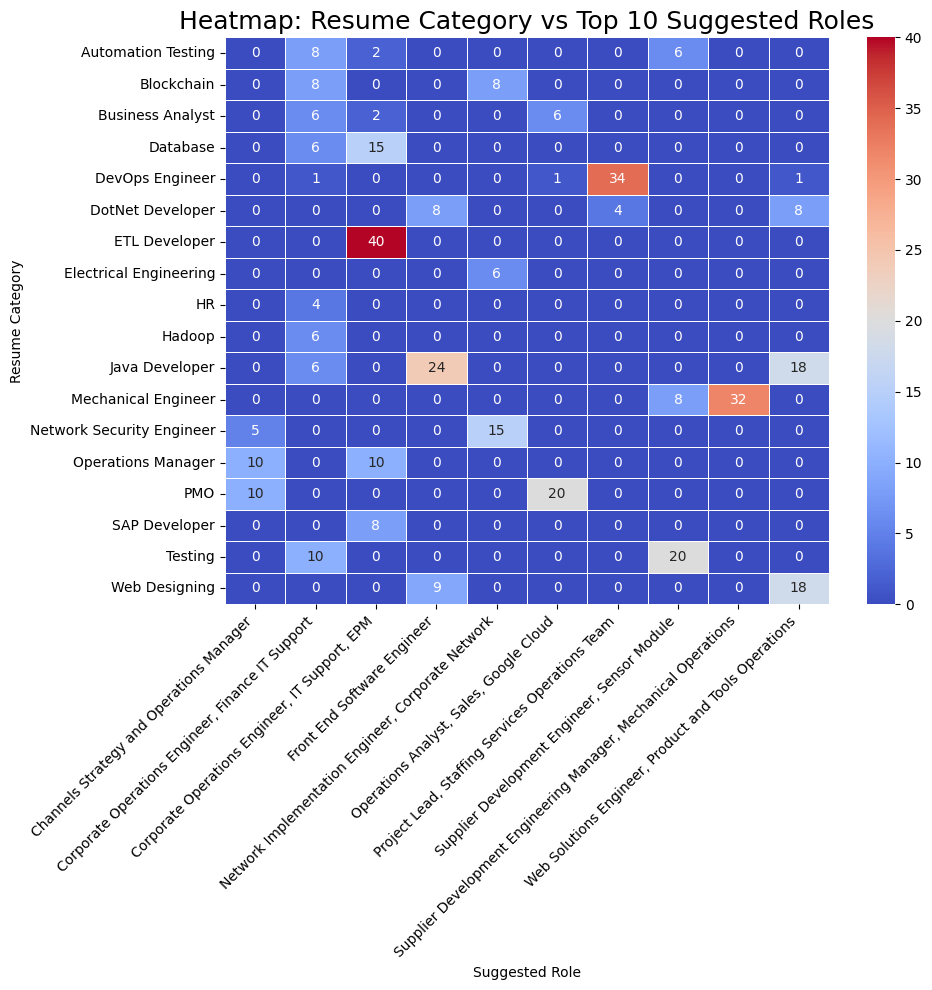

C:\Users\maxim\AppData\Local\Temp\ipykernel_3812\2774047328.py:132: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='Category', order=df['Category'].value_counts().index, palette="Pastel1")


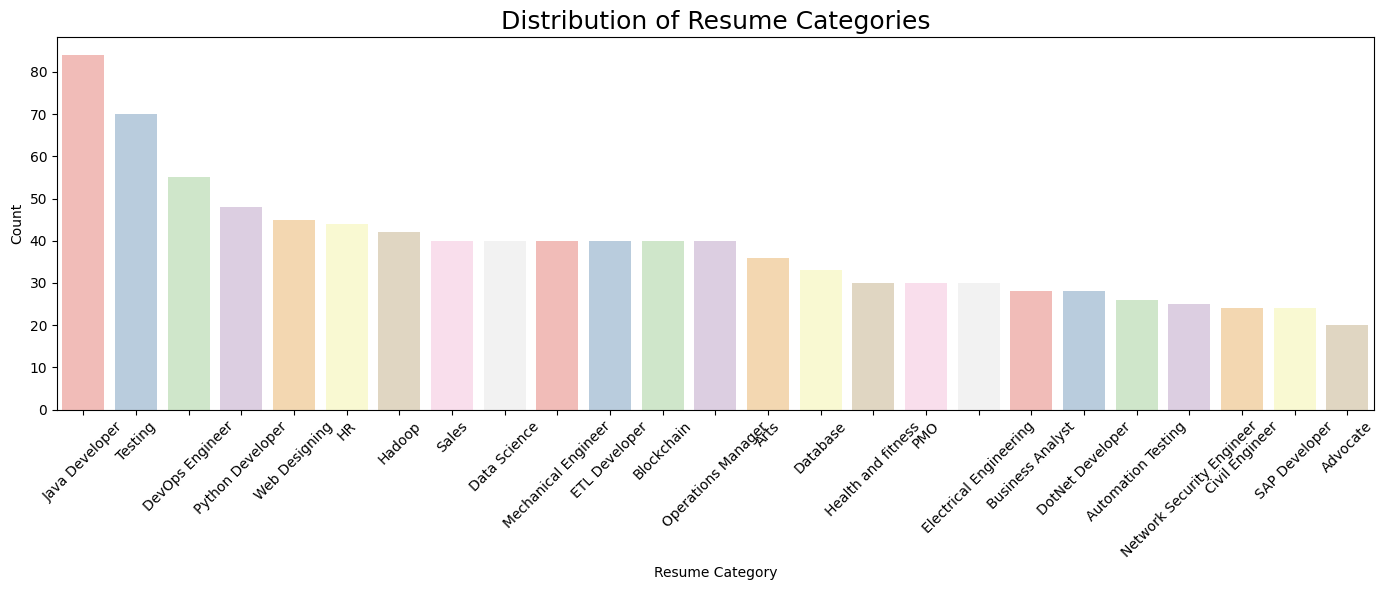

In [2]:
import pandas as pd
from sentence_transformers import SentenceTransformer, util
import fitz  # For reading PDF files
import pytesseract   # For OCR (if PDF is scanned)
from PIL import Image   # Used to convert PDF pages into images for OCR
import os # For file handling
import matplotlib.pyplot as plt
import seaborn as sns


# ========== STEP 1: Dataset Analysis ==========

# Load Resume Dataset
resume_df = pd.read_csv("UpdatedResumeDataSet.csv")
resume_df.columns = ['Category', 'Resume']
resume_df = resume_df.fillna("")

# Load Career Dataset
career_df = pd.read_csv("job_skills.csv")
career_df.columns = ['Company', 'Title', 'Category', 'Location', 'Responsibilities', 'Min_Qualifications', 'Pref_Qualifications']
career_df = career_df.fillna("")

# Combine job description fields
career_df['Job_Description'] = (
    career_df['Title'] + " " +
    career_df['Responsibilities'] + " " +
    career_df['Min_Qualifications'] + " " +
    career_df['Pref_Qualifications']
)

# Load Sentence-BERT model
model = SentenceTransformer('all-MiniLM-L6-v2')

# Encode text
resume_embeddings = model.encode(resume_df['Resume'].tolist(), convert_to_tensor=True)
job_embeddings = model.encode(career_df['Job_Description'].tolist(), convert_to_tensor=True)

# Compute similarity
similarity_scores = util.cos_sim(resume_embeddings, job_embeddings)
best_matches = similarity_scores.argmax(dim=1)
matched_jobs = career_df.iloc[best_matches.tolist()].reset_index(drop=True)

# Attach matched info (without company)
resume_df['Best_Matched_Job'] = matched_jobs['Title']
resume_df['Location'] = matched_jobs['Location']

# Save output
resume_df.drop(columns=['Company'], errors='ignore').to_csv("matched_resumes_dataset.csv", index=False)
print("✅ Dataset-based role matching complete. Output saved to 'matched_resumes_dataset.csv'.")

# ========== STEP 2: Optional Resume Upload ==========

def extract_text_from_pdf(path):
    doc = fitz.open(path)
    text = ""
    for page in doc:
        text += page.get_text()
    return text.strip()

def extract_text_with_ocr(path):
    doc = fitz.open(path)
    text = ""
    for page in doc:
        pix = page.get_pixmap()
        img = Image.frombytes("RGB", [pix.width, pix.height], pix.samples)
        text += pytesseract.image_to_string(img)
    return text.strip()

upload = input("\n📤 Do you want to upload your own resume as a PDF for analysis?\nType 'yes' to upload, or press Enter to skip: ")

if upload.lower() == 'yes':
    pdf_path = input("📄 Enter path to your resume (e.g., resume.pdf): ").strip()

    if os.path.exists(pdf_path):
        print("📄 Extracting text from resume...")
        resume_text = extract_text_from_pdf(pdf_path)

        if not resume_text:
            print("⚠️ No readable text found in the PDF (might be scanned). Trying OCR...")
            resume_text = extract_text_with_ocr(pdf_path)

        if not resume_text:
            print("❌ Unable to extract text even with OCR. Please use a text-based PDF.")
        else:
            print("✅ Resume text extracted. Analyzing...")
            uploaded_embedding = model.encode([resume_text], convert_to_tensor=True)
            scores = util.cos_sim(uploaded_embedding, job_embeddings)
            best_match_idx = scores.argmax().item()
            best_match = career_df.iloc[best_match_idx]
            print("\n🎯 Suggested Role Based on Your Resume:")
            print(f"Role: {best_match['Title']}")
            print(f"📍 Location: {best_match['Location']}")
            print(f"📝 Job Description: {best_match['Job_Description'][:400]}...")
    else:
        print("❌ File not found. Please check the path.")
else:
    print("👋 Skipped custom resume upload.")

# ========== STEP 3: Visualization ==========

print("\n📊 Generating advanced visualizations...")

# Reload without company column
df = pd.read_csv("matched_resumes_dataset.csv")

# Get top 10 most frequent roles
top_10_roles = df['Best_Matched_Job'].value_counts().nlargest(10)

# Pie Chart: Top 10 Roles Only
plt.figure(figsize=(12, 10))
top_10_roles.plot(kind='pie', autopct='%1.1f%%', colors=sns.color_palette("Set3", len(top_10_roles)), startangle=90, legend=False)
plt.title("Top 10 Most Frequent Suggested Roles (Pie Chart)", fontsize=18)
plt.ylabel("")  # Hide y-label
plt.tight_layout()
plt.show()


# Heatmap: Resume Category vs Top 10 Suggested Roles
top_10_roles_df = df[df['Best_Matched_Job'].isin(top_10_roles.index)]
plt.figure(figsize=(10, 10))
heatmap_data = pd.crosstab(top_10_roles_df['Category'], top_10_roles_df['Best_Matched_Job'])
sns.heatmap(heatmap_data, cmap="coolwarm", linewidths=0.5, linecolor='white', annot=True)
plt.title("Heatmap: Resume Category vs Top 10 Suggested Roles", fontsize=18)
plt.xlabel("Suggested Role")
plt.ylabel("Resume Category")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

# 1. Count Plot: Resume Category Frequency
plt.figure(figsize=(14, 6))
sns.countplot(data=df, x='Category', order=df['Category'].value_counts().index, palette="Pastel1")
plt.title("Distribution of Resume Categories", fontsize=18)
plt.xlabel("Resume Category")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Enter the career role (e.g., Data Scientist, MBA, Python Developer):  data scientist



📝 INTERVIEW QUESTIONS:

Here are 20 technical and behavioral interview questions for a data scientist role:

**Technical Questions**

1. What is the difference between supervised and unsupervised learning, and when would you use each?
2. How do you handle missing values in a dataset? Provide examples of techniques you've used in the past.
3. Explain the concept of dimensionality reduction and its applications in data science.
4. Can you describe a scenario where you'd use clustering algorithms (e.g., k-means, hierarchical clustering)? Walk me through your thought process.
5. How do you choose the best metric to evaluate model performance for a specific problem? Provide examples.
6. What is the difference between a regression and classification problem? When would you use each?
7. Can you explain how to implement a linear regression model in Python using scikit-learn or TensorFlow?
8. How do you optimize the hyperparameters of a machine learning model?
9. What is the concept of overfit

✅ Press Enter when you're ready to upload your file... 
📄 Enter your file name (e.g., user_answers.pdf or .docx):  user ans.docx



📝 USER ANSWERS (Preview):

Technical Questions

Difference between supervised and unsupervised learning:


Supervised learning uses labeled data to predict outcomes (e.g., regression, classification).


Unsupervised learning identifies hidden patterns in unlabeled data (e.g., clustering, dimensionality reduction).


Use supervised for tasks like spam detection; unsupervised for customer segmentation.


Handling missing values:


Techniques include:


Removing rows/columns with too many missing values.


Imputation (mean/median for numerical, mode for categorical).


Using models like KNN or regression for advanced imputation.


In a past project, I used median imputation for skewed numeric features to avoid outlier influence.


Dimensionality reduction:


Reduces the number of features while preserving important information.


Techniques: PCA, t-SNE, UMAP.


Applied PCA in a customer churn model to reduce multicollinearity and improve model performance.


Clustering scenario:


Used k

C:\Users\maxim\AppData\Local\Temp\ipykernel_10472\2651458248.py:59: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\maxim\AppData\Local\Programs\Python\Python312\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


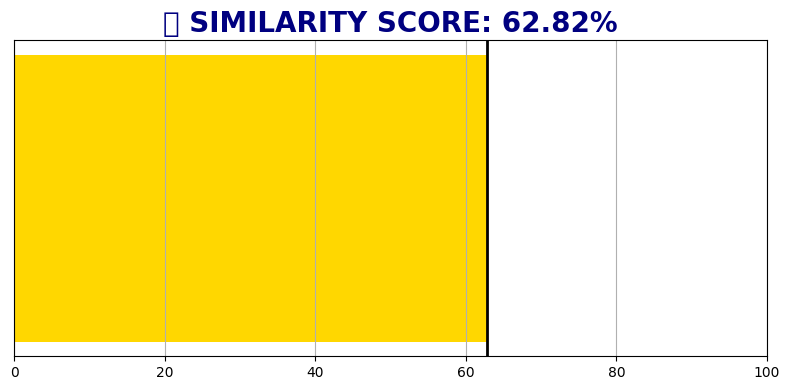


🧠 AI FEEDBACK:

**Rating the User's Skill Level**

Based on the evaluation, I would rate the user's skill level as Intermediate.

They have demonstrated a good understanding of various data science concepts, including supervised and unsupervised learning, handling missing values, dimensionality reduction, clustering, regression vs classification, hyperparameter optimization, and overfitting. However, there are some areas where they could improve, such as providing more detailed examples or explaining technical concepts in greater depth.

**What They Did Well**

The user did well in:

1. Clearly explaining the difference between supervised and unsupervised learning.
2. Providing a comprehensive list of techniques for handling missing values.
3. Describing their approach to clustering and dimensionality reduction.
4. Discussing the importance of evaluation metrics in classification problems.
5. Highlighting the role of feature engineering in improving model performance.

**What They Mis


💬 Ask your question to the AI mentor (or type 'no' to exit):  How can I enhance my AI-based resume-job matching system to make it more accurate and user-friendly?



🧠 Mentor's Answer:
 Enhancing an AI-based resume-job matching system requires a combination of data analysis, machine learning, and user feedback. Here are some strategies to improve the accuracy and user-friendliness of your system:

1. **Data Quality Improvement**: Ensure that your dataset is comprehensive, up-to-date, and diverse. Include relevant information about jobs, companies, and candidates, such as job descriptions, required skills, and candidate profiles.
2. **Keyword Extraction and Tokenization**: Use natural language processing (NLP) techniques to extract keywords from resumes and job postings. This will help the system understand the relevance of candidate skills to job requirements.
3. **Candidate Profiling and Skill Modeling**: Create detailed profiles for each candidate, including their skills, experience, and education. Use machine learning algorithms to model the relationships between these attributes and predict a candidate's fit for a job.
4. **Job Postings Analys


💬 Ask your question to the AI mentor (or type 'no' to exit):  no



✅ All done! Keep practicing and good luck on your career journey!


In [17]:
import ollama  # For AI chat using LLaMA 3.2
import os   # To work with file paths
import time   # To track execution time
import docx2txt # To extract text from .docx files
from PyPDF2 import PdfReader    # To read PDF files
from sklearn.feature_extraction.text import TfidfVectorizer   # To convert text into numerical vectors
from sklearn.metrics.pairwise import cosine_similarity    # To measure text similarity
import matplotlib.pyplot as plt   
import numpy as np
from fpdf import FPDF  # To generate PDF feedback

# === Timer Start ===
start_time = time.time()

# === Input Role ===
role = input("Enter the career role (e.g., Data Scientist, MBA, Python Developer): ").strip()

def generate_questions(career):
    prompt = f"Generate 20 technical and behavioral interview questions for a {career} role."
    response = ollama.chat(model="llama3.2", messages=[{"role": "user", "content": prompt}])
    return response["message"]["content"]

def generate_ideal_answers(career, questions):
    prompt = f"Provide ideal, concise answers for the following {career} interview questions:\n\n{questions}"
    response = ollama.chat(model="llama3.2", messages=[{"role": "user", "content": prompt}])
    return response["message"]["content"]

def read_user_answer(file_path):
    if not os.path.exists(file_path):
        print("❌ File not found.")
        return None
    if file_path.endswith(".pdf"):
        text = ""
        with open(file_path, "rb") as f:
            reader = PdfReader(f)
            for page in reader.pages:
                text += page.extract_text() or ""
        return text.strip()
    elif file_path.endswith(".docx"):
        return docx2txt.process(file_path).strip()
    else:
        print("❌ Unsupported file type. Please use PDF or DOCX.")
        return None

def calculate_similarity(user_text, ideal_text):
    vectorizer = TfidfVectorizer()
    vectors = vectorizer.fit_transform([user_text, ideal_text])
    similarity_matrix = cosine_similarity(vectors)
    return round(similarity_matrix[0][1] * 100, 2)

def plot_similarity_gauge(score):
    fig, ax = plt.subplots(figsize=(8, 4))
    ax.set_xlim(0, 100)
    ax.barh([0], [score], color='limegreen' if score > 70 else 'gold' if score > 40 else 'tomato', height=0.5)
    ax.set_yticks([])
    ax.set_title(f"🎯 SIMILARITY SCORE: {score}%", fontsize=20, fontweight='bold', color='navy')
    ax.axvline(x=score, color='black', linewidth=2)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def clean_text_for_pdf(text):
    replacements = {
        '“': '"', '”': '"', '’': "'", '‘': "'", '—': '-', '–': '-',
        '•': '*', '…': '...', '→': '->'
    }
    for old, new in replacements.items():
        text = text.replace(old, new)
    return text.encode('latin-1', 'ignore').decode('latin-1')

def save_feedback_to_pdf(feedback_text, filename="interview_feedback.pdf"):
    pdf = FPDF()
    pdf.add_page()
    pdf.set_auto_page_break(auto=True, margin=15)
    pdf.set_font("Arial", size=12)

    lines = feedback_text.split('\n')
    for line in lines:
        clean_line = clean_text_for_pdf(line)
        pdf.multi_cell(0, 10, clean_line)

    pdf.output(filename)
    print(f"\n📄 Feedback saved as: {filename}")

# === Run Interview Flow ===
questions = generate_questions(role)
print("\n📝 INTERVIEW QUESTIONS:\n")
print(questions)

print("\n📂 Please answer these questions in a DOCX or PDF file.")
input("✅ Press Enter when you're ready to upload your file...")

file_path = input("📄 Enter your file name (e.g., user_answers.pdf or .docx): ").strip()
user_text = read_user_answer(file_path)

if user_text:
    print("\n📝 USER ANSWERS (Preview):\n")
    print(user_text[:1000] + "\n..." if len(user_text) > 1000 else user_text)

    # Generate AI answers
    ai_answers = generate_ideal_answers(role, questions)
    print("\n💡 IDEAL ANSWERS (AI Generated):\n")
    print(ai_answers)

    # === Calculate Similarity ===
    score = calculate_similarity(user_text, ai_answers)
    plot_similarity_gauge(score)

    # === Generate Feedback ===
    prompt = f"""
Act as a professional interviewer for a {role} role.

Evaluate the following:
=== USER ANSWERS ===
{user_text}

=== IDEAL ANSWERS ===
{ai_answers}

Similarity Score: {score}%

Your tasks:
1. Rate the user's skill level (Beginner, Intermediate, Advanced)
2. Mention what they did well
3. Mention what they missed
4. Suggest exact skills to improve
5. For each improvement area, recommend a real course with the platform name and URL (like Coursera, edX, Udemy)
6. End with an inspiring quote and say: "✅ This role is suitable for your career path — stay focused and keep growing!"
"""
    feedback_response = ollama.chat(model="llama3.2", messages=[{"role": "user", "content": prompt}])
    feedback_text = feedback_response["message"]["content"]

    print("\n🧠 AI FEEDBACK:\n")
    print(feedback_text)

    save_feedback_to_pdf(feedback_text)

    # === AI Mentor Chat Mode ===
    print("\n🤖 You can now chat with the AI mentor for follow-up questions!")
    while True:
        follow_up = input("\n💬 Ask your question to the AI mentor (or type 'no' to exit): ").strip()
        if follow_up.lower() == "no":
            print("\n✅ All done! Keep practicing and good luck on your career journey!")
            break
        mentor_response = ollama.chat(model="llama3.2", messages=[{"role": "user", "content": follow_up}])
        print("\n🧠 Mentor's Answer:\n", mentor_response["message"]["content"])

else:
    print("❗ Could not read the user answer file. Check the format and try again.")
